In [2]:
import sys
sys.path.append('../')

In [3]:
import datetime
from pprint import pprint
from typing import List

import matplotlib.pyplot as plt
import pandas as pd
import torch
from safetensors.torch import save_file
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer

from utils.ClassifierModel import ClassifierModel

c:\Users\hiroga\miniconda3\envs\chiikawa-yonezu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
class TextDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_len=20):
        self.dataframe = pd.read_csv(csv_file)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx, 0]
        label = 0 if self.dataframe.iloc[idx, 1] == 'ちいかわ' else 1
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = inputs['input_ids'].flatten()
        attention_mask = inputs['attention_mask'].flatten()
        return input_ids, attention_mask, label

In [5]:
def labels_to_nihongos(labels: List[int]) -> List[str]:
    return ['ちいかわ' if label == 0 else '米津玄師' for label in labels]

def outputs_to_nihongos(outputs: torch.Tensor) -> List[str]:
    return ['ちいかわ' if output[0] > output[1] else '米津玄師' for output in outputs]

In [6]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
pprint(f'device: {device}')

'device: cuda'


In [7]:
def to_device(device, *args):
    return [x.to(device) for x in args]

In [8]:
tokenizer = BertTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')
train_dataset = TextDataset('../data/data_preprocessed_train.csv', tokenizer, 20)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TextDataset('../data/data_preprocessed_test.csv', tokenizer, 20)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertJapaneseTokenizer'. 
The class this function is called from is 'BertTokenizer'.


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\hiroga\miniconda3\envs\chiikawa-yonezu\Lib\site-packages\transformers\tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


[(tensor(1, device='cuda:0'),
  '米津玄師',
  tensor([-0.5309,  0.2766], device='cuda:0', grad_fn=<UnbindBackward0>),
  '米津玄師'),
 (tensor(0, device='cuda:0'),
  'ちいかわ',
  tensor([-0.4974,  0.3998], device='cuda:0', grad_fn=<UnbindBackward0>),
  '米津玄師'),
 (tensor(1, device='cuda:0'),
  '米津玄師',
  tensor([-0.5252,  0.6260], device='cuda:0', grad_fn=<UnbindBackward0>),
  '米津玄師'),
 (tensor(1, device='cuda:0'),
  '米津玄師',
  tensor([-0.5027,  0.2697], device='cuda:0', grad_fn=<UnbindBackward0>),
  '米津玄師'),
 (tensor(0, device='cuda:0'),
  'ちいかわ',
  tensor([-0.8222,  0.2970], device='cuda:0', grad_fn=<UnbindBackward0>),
  '米津玄師'),
 (tensor(0, device='cuda:0'),
  'ちいかわ',
  tensor([-0.7569,  0.4962], device='cuda:0', grad_fn=<UnbindBackward0>),
  '米津玄師'),
 (tensor(1, device='cuda:0'),
  '米津玄師',
  tensor([-0.6752,  0.3011], device='cuda:0', grad_fn=<UnbindBackward0>),
  '米津玄師'),
 (tensor(0, device='cuda:0'),
  'ちいかわ',
  tensor([-0.8031,  0.4092], device='cuda:0', grad_fn=<UnbindBackward0>),
  '米津玄師'),


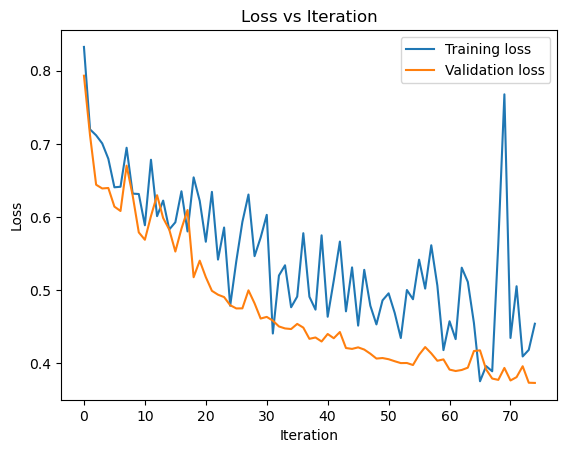

In [9]:
epoch = 1
net: torch.nn.Module = ClassifierModel().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

train_loss_values = []  # List to store loss values
test_loss_values = []  # List to store loss values

debug_head = 10

for e in range(epoch):
    for input_ids, attention_mask, labels in train_loader:
        """Training loop"""
        net.train()
        input_ids, attention_mask, labels = to_device(device, input_ids, attention_mask, labels)
        optimizer.zero_grad()
        outputs = net(input_ids, attention_mask)
        pprint(list(zip(labels, labels_to_nihongos(labels), outputs, outputs_to_nihongos(outputs)))[:debug_head])
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        pprint(f'train_loss: {loss.item()}')
        train_loss_values.append(loss.item())  # Append loss value to the list

        """Validation loop"""
        net.eval()
        test_loss = 0.0
        num_batches = 0
        with torch.no_grad():
            for test_input_ids, test_attention_mask, test_labels in test_loader:
                test_input_ids, test_attention_mask, test_labels = to_device(device, test_input_ids, test_attention_mask, test_labels)
                test_outputs = net(test_input_ids, test_attention_mask)
                test_inputs_decoded = [tokenizer.decode(x) for x in test_input_ids]

                pprint(list(zip(test_inputs_decoded, test_labels, labels_to_nihongos(test_labels), test_outputs, outputs_to_nihongos(test_outputs)))[:debug_head])

                batch_test_loss = torch.nn.functional.cross_entropy(test_outputs, test_labels)
                test_loss += batch_test_loss.item()
                num_batches += 1

        avg_test_loss = test_loss / num_batches
        pprint(f'test_loss: {avg_test_loss}')
        test_loss_values.append(avg_test_loss)

current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_save_path = f"../models/model_{current_time}.safetensors"
tensors = {name: param for name, param in net.named_parameters()}
save_file(tensors, model_save_path)
print(f"Model saved to {model_save_path}")

# Plot the loss values
plt.plot(train_loss_values, label='Training loss')
plt.plot(test_loss_values, label='Validation loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Iteration')
plt.show()


In [10]:
from safetensors import safe_open

tensors = {}
with safe_open(model_save_path, framework="pt", device="cpu") as f:
    for key in f.keys():
        tensors[key] = f.get_tensor(key)

inference_model: torch.nn.Module = ClassifierModel().to(device)
inference_model.load_state_dict(tensors)

<All keys matched successfully>

In [11]:
import torch
from transformers import BertTokenizer

def classify_text(model, text, tokenizer, max_length=20):
    """
    モデルとテキストを受け取り、'ちいかわ' と '米津玄師' のどちらに該当するかの確率を出力する。

    Args:
    model (torch.nn.Module): 分類モデル。
    text (str): 分類するテキスト。
    tokenizer (BertTokenizer): 使用するトークナイザー。
    max_length (int): トークナイザーの最大長。

    Returns:
    tuple: 'ちいかわ' の確率, '米津玄師' の確率
    """

    # テキストをトークナイズし、PyTorchのテンソルに変換
    inputs = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    pprint(f"inputs: {inputs}")

    # モデルの推論
    model.eval()
    with torch.no_grad():
        outputs = model(inputs['input_ids'].to(device), inputs['attention_mask'].to(device))
        pprint(f"outputs: {outputs}")
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

    # 確率の取得
    chiikawa_prob = probabilities[0][0].item()
    yonezu_prob = probabilities[0][1].item()

    return chiikawa_prob, yonezu_prob


In [12]:
tokenizer = BertTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')
chiikawa_prob, yonezu_prob = classify_text(inference_model, "晴れた空に種を蒔こう", tokenizer)

print(f"ちいかわ: {chiikawa_prob}, 米津玄師: {yonezu_prob}")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertJapaneseTokenizer'. 
The class this function is called from is 'BertTokenizer'.


("inputs: {'input_ids': tensor([[    2,  4798,    20, 28447,   454,     7,   "
 '494,    11, 27694,  1018,\n'
 '             3,     0,     0,     0,     0,     0,     0,     0,     0,     '
 "0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, "
 "0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, "
 '1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}')
"outputs: tensor([[-1.1210,  0.4139]], device='cuda:0')"
ちいかわ: 0.1772868037223816, 米津玄師: 0.8227131366729736
